In [28]:
import pandas as pd
import os
import re

from wsi.utils import raw_data_path, processed_data_path

safety_index = pd.read_csv(processed_data_path('womens_safety_index_baseline.csv')).dropna(subset="WSI (Baseline)") # ?? dont look at countries with no index
disaster_df = pd.read_csv(processed_data_path('shocks', 'death_disasters.csv'), index_col=0).rename(columns={'Total Deaths (%)':'Disaster Deaths','Total Affected (%)':'Disaster Affected'})

In [29]:
directory = processed_data_path("shocks", "proximity_conflict")
conflict_dfs = []

for filename in os.listdir(directory):
    if filename.startswith("conflict_summary_") and filename.endswith(".csv"):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        df = df.rename(columns={
            'iso3': 'ISO_code',
            'percent': 'Conflict Population',
            'year': 'Year'
        })
        conflict_dfs.append(df)

conflict_df = pd.concat(conflict_dfs, ignore_index=True)


# missing data for conflict

In [30]:
# Unique ISO_codes in safety_index
safety_iso = set(safety_index['ISO_code'].unique())

# ISO_codes present in conflict_df and disaster_df (dropping NaNs)
conflict_iso = set(conflict_df['ISO_code'].dropna().unique())
disaster_iso = set(disaster_df['ISO_code'].dropna().unique())

# Find ISO_codes that are in safety_index but not in conflict_df
no_conflict = safety_iso - conflict_iso

# Find ISO_codes that are in safety_index but not in disaster_df
no_disaster = safety_iso - disaster_iso

# Get the union of both sets: ISO_codes with no conflict data or no disaster data
result = no_conflict.union(no_disaster)

print(result)


{'BHR', 'CAF', 'USA', 'UKR', 'MKD', 'KIR', 'PLW', 'QAT', 'ISL', 'HKG', 'TUV', 'ERI', 'PRI', 'TZA', 'NGA', 'SMR', 'BRN', 'MNE', 'CPV', 'AUT', 'SVK', 'NRU', 'ATG', 'CHE'}


# Combine: create shock indicator

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# merge
# TODO: change so we know data missingness
merged_df = conflict_df.merge(disaster_df, on=['ISO_code', 'Year'], how='inner')

# normalise
cols_to_normalize = ['Conflict Population', 'Disaster Deaths', 'Disaster Affected']
for col in cols_to_normalize:
    min_val = merged_df[col].min()
    max_val = merged_df[col].max()
    merged_df[col + ' (score)'] = (merged_df[col] - min_val) / (max_val - min_val)
    
merged_df['Shocks_raw'] = merged_df[[col + ' (score)' for col in cols_to_normalize]].mean(axis=1)
shock_df = merged_df
shock_df.sort_values(by=['ISO_code', 'Year'], inplace=True)

# EWMA
shock_df['Shocks'] = shock_df.groupby('ISO_code')['Shocks_raw'] \
                                  .transform(lambda x: x.ewm(span=5, adjust=False).mean())*100.

# filter
shock_df = shock_df[['ISO_code', 'Year', 'Conflict Population', 'Disaster Deaths', 'Disaster Affected',
       'Conflict Population (score)', 'Disaster Deaths (score)',
       'Disaster Affected (score)', 'Shocks']]

final_df = safety_index.merge(shock_df, on=['ISO_code', 'Year'], how='left')

# WSI minus shocks

In [32]:
alpha = 0.5
final_df['WSI'] = final_df["WSI (Baseline)"] - alpha * final_df['Shocks']
final_df['WSI'] = final_df['WSI'].clip(lower=0)

final_df.to_csv(processed_data_path('womens_safety_index.csv'))

<Axes: >

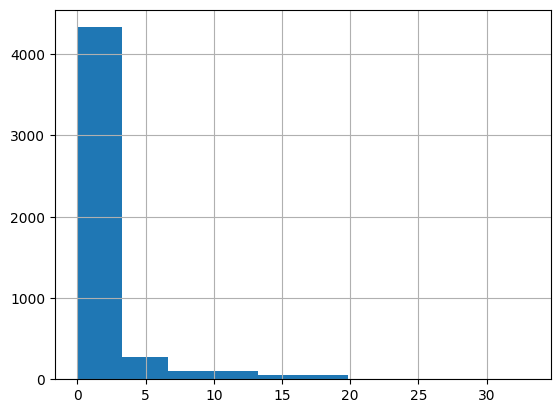

In [33]:
final_df['Shocks'].hist()